In [1]:
#installed packages;
!pip install networkx==3.4.2
!pip install matplotlib
!pip install ijson
!pip install -qU langchain[openai]
!pip install -qU langchain_community
!pip install langgraph
!pip install nx-arangodb
!pip install -U langchain-groq
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com
!pip install adbnx-adapter
!pip install gradio
!pip install gitingest
!pip install uuid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4
    Uninstalling networkx-3.4:
      Successfully uninstalled networkx-3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-arangodb 1.3.0 requires networkx<=3.4,>=3.0, but you have networkx 3.4.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", bu

In [2]:
import os
import base64
import re
import uuid
import logging
import random
from google.colab import userdata
import matplotlib.pyplot as plt
import ijson
import asyncio
import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
from arango import ArangoClient
from adbnx_adapter import ADBNX_Adapter, ADBNX_Controller
from adbnx_adapter.typings import NxId, NxData
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs.arangodb_graph import ArangoGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import StructuredTool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END
import gradio as gr
from gradio import ChatMessage
from gitingest import ingest_async
import subprocess
import logging
import math

[09:31:31 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [3]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [4]:
logger = logging.getLogger()

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    filename="app.log",
    filemode="a"
)
logger.setLevel(logging.INFO)

In [5]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
%env NX_CUGRAPH_AUTOCONFIG=True
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]
programmingLanguageDict = {
    "c#": "c_sharp", # to avoid clashing with the arangodb key nameing conventions
}


env: NX_CUGRAPH_AUTOCONFIG=True


In [6]:
encodedCA = userdata.get("SIGNATURE")
try:
    file_content = base64.b64decode(encodedCA)
    with open("cert_file.crt", "w+") as f:
        f.write(file_content.decode("utf-8"))
except Exception as e:
    print(str(e))
    exit(1)

client = ArangoClient(
      hosts=userdata.get("DATABASE_HOST"), verify_override="cert_file.crt"
)

  # Connect to the correct database
db = client.db(
    userdata.get('DATABASE_NAME'),
    username=userdata.get("DATABASE_USERNAME"),
    password=userdata.get("DATABASE_PASSWORD")
)

Nodes are structured in the following format with the **key** attribute as an additional property:

- **Forked as a main node**  
  1. **Repo** (stars, forks, repoLink, description)  
  2. **Owner**  
  3. **Language**  

### Edges:  
1. **Repo** ⟷ **Owner**  
2. **Repo** ⟷ **Languages**  
3. **Repo** ⟷ **Topic**  
4. **Repo** ⟷ **Forked**  

In [7]:

def sanitiseText(text):
    if not text:
        return None

    pattern = r'[^A-Za-z0-9_\-\.@()+,=;$!*\'% ]'

    # Extract URLs from text
    urls = re.findall(r'https?://\S+', text)

    sanitized_text = re.sub(pattern, '_', text)

    # Restore original URLs
    for url in urls:
        sanitized_text = sanitized_text.replace(re.sub(pattern, '_', url), url)

    return sanitized_text

In [8]:
def createNetworkxGraph()-> nx.Graph:
    file_path = "/content/drive/MyDrive/repo_metadata.json" ## file path of the data to be processed

    G = nx.Graph()

    with open(file_path, 'r') as f:
        parser = ijson.items(f, 'item')
        G.add_node("forked", type="isFork", key="forked")
        for row in parser:

            # For repo name
            repoName = sanitiseText(row["name"])
            if repoName is not None and repoName:
              repoNodeKey = f"repository-{repoName}"
              if not G.has_node(repoNodeKey):
                G.add_node(repoNodeKey, type="repository", stars=row["stars"], forks=row["forks"], key=repoNodeKey, repoLink=row["nameWithOwner"], description = row["description"], size= row["diskUsageKb"], createdDate = row["createdAt"])

            # For owner
            owner = sanitiseText(row["owner"])
            if owner is not None and owner:
                ownerNodeKey = f"owner-{owner}"
                if not G.has_node(ownerNodeKey):
                    G.add_node(ownerNodeKey, type="owner", key=ownerNodeKey)
                if not G.has_edge(repoNodeKey, ownerNodeKey):
                    G.add_edge(repoNodeKey, ownerNodeKey, relation="owner")

            if row["isFork"]:
                G.add_edge(repoName, "forked", relation="isForkRepo")


            # For topic
            for topic in row.get("topics", []):
                topicName = sanitiseText(topic.get("name"))
                if topicName is not None and topicName:
                    topicNodeKey = f"topic-{topicName}"
                    if not G.has_node(topicNodeKey):
                        G.add_node(topicNodeKey, type="topic", key=topicNodeKey)
                    if not G.has_edge(repoNodeKey, topicNodeKey):
                        G.add_edge(repoNodeKey, topicNodeKey, relation="topic")


            # For Programming Language
            filePercentage = sum(map(lambda lang: lang["size"], row["languages"] if row["languages"] is not None else []))
            for proLang in row["languages"]:
                proLangName = sanitiseText(proLang.get("name"))
                proLangSize = proLang.get("size", 0)
                if proLangName is not None and proLangName:
                    proLangNodeKey = f"language-{proLangName}"
                    if not G.has_node(proLangNodeKey):
                        G.add_node(proLangNodeKey, type="language", key=proLangNodeKey)
                    if not G.has_edge(repoNodeKey, proLangNodeKey):
                        percentage = round(((proLangSize) / filePercentage) * 100 if filePercentage else 0)
                        G.add_edge(repoNodeKey, proLangNodeKey, relation="language", percent_used = percentage)


        return G






5323481


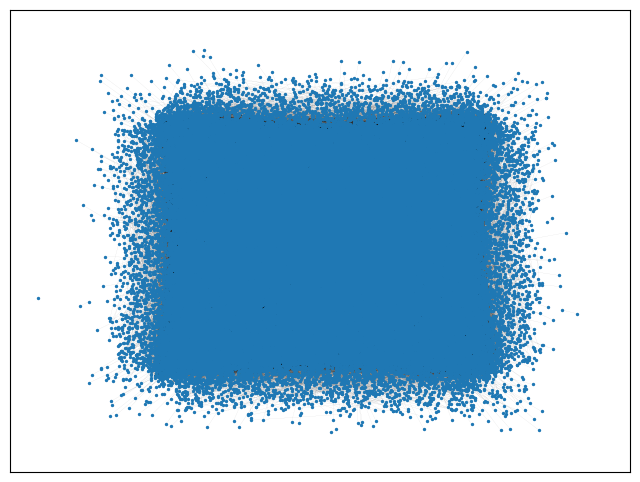

In [ ]:
def plotGraph(G):
  G_sample = G.subgraph(list(G.nodes)[:100000])
  plot_options = {"node_size": 2, "with_labels": False, "width": 0.02}
  pos = nx.spring_layout(G_sample, iterations=2, seed=1721)  # Use sample graph
  fig, ax = plt.subplots(figsize=(8, 6))
  nx.draw_networkx(G_sample, pos=pos, ax=ax, **plot_options)
  plt.show()

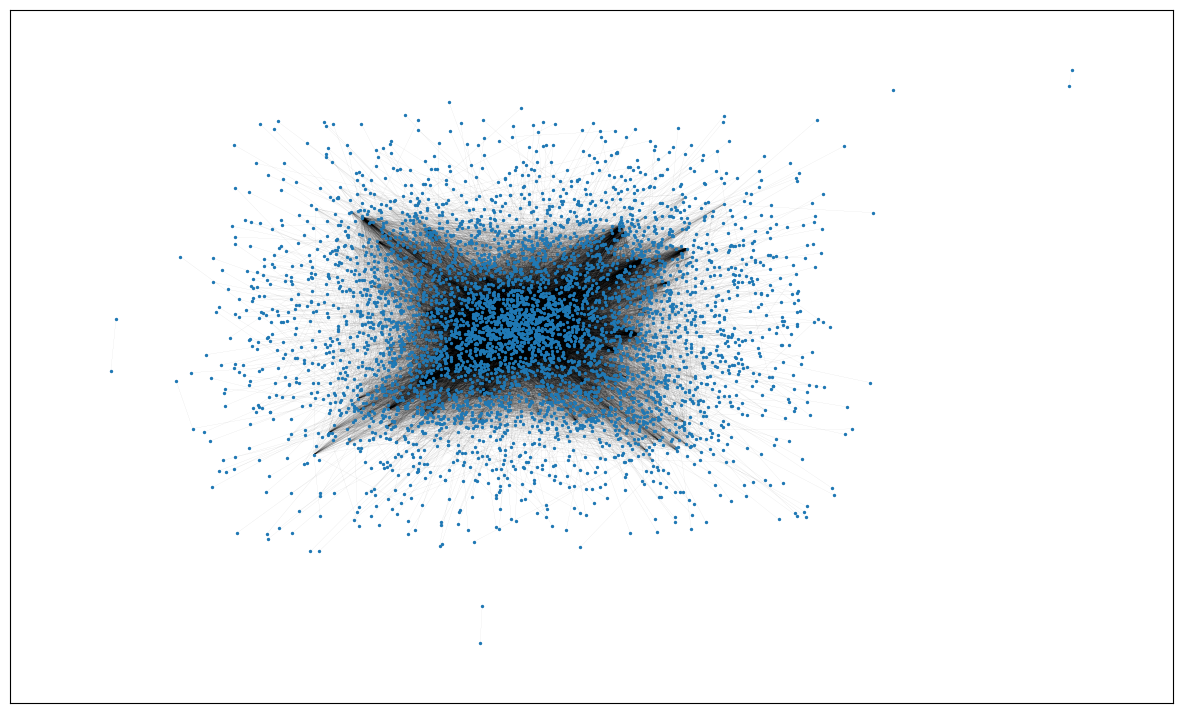

In [ ]:
def plotSubGraph(G):
  G_sample = G.subgraph(list(G.nodes)[:5000])
  plot_options = {"node_size": 2, "with_labels": False, "width": 0.02}
  pos = nx.spring_layout(G_sample, iterations=5, seed=1721)  # Use sample graph
  fig, ax = plt.subplots(figsize=(15, 9))
  nx.draw_networkx(G_sample, pos=pos, ax=ax, **plot_options)
  plt.show()

In [9]:
def uploadNetworkGraphIntoArangodb(G):

  class CustomController(ADBNX_Controller):
      def _keyify_networkx_node(
          self, i: int, nx_node_id: NxId, nx_node: NxData, col: str
      ) -> str:
          """Given a NetworkX node, derive its ArangoDB key.

          NOTE #1: You must override this function if you want to create custom ArangoDB
          _key values for your NetworkX nodes.

          NOTE #2: You are free to use `_string_to_arangodb_key_helper()` and
          `_tuple_to_arangodb_key_helper()` to derive a valid ArangoDB _key value.

          :param i: The index of the NetworkX node in the list of nodes.
          :type i: int
          :param nx_node_id: The NetworkX node id.
          :type nx_node_id: adbnx_adapter.typings.NxId
          :param nx_node: The NetworkX node object.
          :type nx_node: adbnx_adapter.typings.NxData
          :param col: The ArangoDB collection that **nx_node** belongs to.
          :type col: str
          :return: A valid ArangoDB _key value.
          :rtype: str
          """
          return (nx_node.get("key", str(uuid.uuid4())));

      def _prepare_networkx_edge(self, nx_edge: dict, col: str) -> None:
        """Prepare a NetworkX edge before it gets inserted into the ArangoDB
        collection **col**.

        :param nx_edge: The NetworkX edge object to (optionally) modify.
        :param col: The ArangoDB collection the edge belongs to.
        """

        if "repository" not in nx_edge.get("_from", ""):
          nx_edge["_from"], nx_edge["_to"] = nx_edge["_to"], nx_edge["_from"]


  adbnx_adapter = ADBNX_Adapter(db, CustomController())

  edge_definitions = [
      {
          'edge_collection': 'Github_node_to_Github_node',
          'from_vertex_collections': ['Github_node'],
          'to_vertex_collections': ['Github_node']
      }
  ]

  adb_g = adbnx_adapter.networkx_to_arangodb(userdata.get("GRAPH_NAME"), G, edge_definitions, batch_size=9000)



In [10]:
def createNetworkxArangoDBGraph():
  graph = createNetworkxGraph()
  plotGraph(graph)
  plotSubGraph(graph)
  uploadNetworkGraphIntoArangodb(graph)

In [11]:
G_adb = nxadb.Graph(name=userdata.get("GRAPH_NAME"), db=db)

if G_adb.number_of_nodes() == 0:
  createNetworkxArangoDBGraph()
else:
  logger.info("Graph is already available")


[09:33:04 +0000] [INFO]: Graph 'Github' exists.
INFO:nx_arangodb:Graph 'Github' exists.
[09:33:04 +0000] [INFO]: Default node type set to 'Github_node'
INFO:nx_arangodb:Default node type set to 'Github_node'
INFO:root:Graph is already available


In [12]:
arangooGraph = ArangoGraph(db)

In [13]:
from pydantic import BaseModel, Field
from typing import List

class Outputresponse(BaseModel):
    """Respond to the user in this format."""
    type: str = Field(description="response type either text")
    text: str = Field(description="response for the user query in simple text")

class OutputList(BaseModel):
    responses: List[Outputresponse] = Field(description="List of Outputresponse objects")


In [51]:
@tool
def humanQueryToAQL(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    If user has any questions or interested in anything related to topics, or repository information like language, stars, author , use this tool, to convert into AQL.
    """

    logger.info("Executing Human Query to AQL")
    query = sanitiseText(query)

    llm = ChatOpenAI(temperature=0.5, model_name="gpt-4o")


    aql_generation_prompt = PromptTemplate(
    input_variables=['adb_schema', 'aql_examples', 'user_input'],
    template="""Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query.

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You may also be given a set of `AQL Query Examples` to help you create the `AQL Query`. Make sure to keep in mind how the nodes, attributes, and edges are structured in order to generate the query.

Nodes/Edges are structured in format:
repoNodeKey = repository-repoName
G.add_node(repoNodeKey, type='repository', stars=row['stars'], forks=row['forks'], key=repoNodeKey, repoLink=row['nameWithOwner'], description = row['description'], size= row['diskUsageKb'])
ownerNodeKey = owner-ownerName
G.add_node(ownerNodeKey, type='owner', key=ownerNodeKey)
topicNodeKey = topic-topicName
G.add_node(topicNodeKey, type='topic', key=topicNodeKey)
proLangNodeKey = language-programmingLanguageName
G.add_edge(repoNodeKey, ownerNodeKey, relation='owner')
G.add_edge(repoName, 'forked', relation='isForkRepo')
G.add_edge(repoNodeKey, topicNodeKey, relation='topic')
G.add_edge(repoNodeKey, proLangNodeKey, relation='language', percent_used = percentage)

Use the format defined to generate the AQL query.

If provided, the `AQL Query Examples` should be used as a reference, similar to how `ArangoDB Schema` should be used.

Things you should do:
- Think step by step.
- Rely on `ArangoDB Schema` and `AQL Query Examples` (if provided) to generate the query.
- Begin the `AQL Query` with the `WITH` AQL keyword to specify all required ArangoDB Collections.
- Return the `AQL Query` wrapped in three backticks (```)
- Use only the provided relationship types and properties in the `ArangoDB Schema` and any `AQL Query Examples`.
- Only answer requests related to generating an AQL Query.
- If a request is unrelated to generating an AQL Query, say that you cannot help the user.
- For every query, return the repoLink for sure.
- Query related to majorly, always try to include relevant metrics if you have it
- If the repo has multiple outputs, always return top 5 ones and make query according to it
- All the query should be in lowercase like topic,
-Also for all the url returned make sure, valid github url is returned, if needed,  include the domain and protocol
- Always limit the search result, if the output gonna be large, say its too large, just give the count and first 5

Things you should not do:
- Do not use any properties/relationships that can't be inferred from the `ArangoDB Schema` or the `AQL Query Examples`.
- Do not include any text except the generated AQL Query.
- Do not provide explanations or apologies in your responses.
- Do not generate an AQL Query that removes or deletes any data.

Under no circumstances should you generate an AQL Query that deletes any data.

ArangoDB Schema:
{adb_schema}

AQL Query Examples (Optional):
{aql_examples}

User Input:
{user_input}

AQL Query:
"""
)

    graph = ArangoGraph(db)

    chain = ArangoGraphQAChain.from_llm(
    llm=llm,
    graph=graph,
    aql_generation_prompt=aql_generation_prompt,
    verbose=True,
    allow_dangerous_requests=True,
    max_aql_generation_attempts=3,
    aql_examples="""
Example 1:
WITH Github_node, Github_node_to_Github_node
FOR owner IN Github_node
  FILTER owner.type == "owner" AND owner.key == "owner-freecodecamp"
  FOR edge IN Github_node_to_Github_node
    FILTER edge._to == owner._id AND edge.relation == "owner"
    FOR repo IN Github_node
      FILTER repo._id == edge._from AND repo.type == "repository"
    LIMIT 5
    RETURN repo


"""
)

    logger.info("Executing Human Query to AQL")

    logger.info(query)


    result = chain.invoke(query)

    return str(result["result"])

      # If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language and if the AQL is gonna be simple, then do not use
      # this tool.

In [50]:
@tool
def networkxAlgorithms(query:str, nodes):
    """This tool is available to invoke a NetworkX Algorithm on
      the ArangoDB Graph. You are responsible for accepting the
      Natural Language Query, establishing which algorithm needs to
      be executed, executing the algorithm, and translating the results back
      to Natural Language, with respect to the original query.

      If the query is related to computation of score using networkx algorithm use it...


      If the query is complicated, and if you think the output of the another tool, or you can solve this query in much faster, use this tool
      """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o", verbose=True)

    ######################
    logger.info("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arangooGraph.schema}

    If needed, create a networkx nodes and egdes and execute the networkx algorithm for it,

    Nodes/Edges are structured in format:
    repoNodeKey = repository-repoName
    G.add_node(repoNodeKey, type='repository', stars=row['stars'], forks=row['forks'], key=repoNodeKey, repoLink=row['nameWithOwner'], description = row['description'], size= row['diskUsageKb'])
    ownerNodeKey = owner-ownerName
    G.add_node(ownerNodeKey, type='owner', key=ownerNodeKey)
    topicNodeKey = topic-topicName
    G.add_node(topicNodeKey, type='topic', key=topicNodeKey)
    proLangNodeKey = language-programmingLanguageName
    G.add_edge(repoNodeKey, ownerNodeKey, relation='owner')
    G.add_edge(repoName, 'forked', relation='isForkRepo')
    G.add_edge(repoNodeKey, topicNodeKey, relation='topic')
    G.add_edge(repoNodeKey, proLangNodeKey, relation='language', percent_used = percentage)

    I have the following graph analysis query: {query}.

    All the information like programming language and everything would be in lowercase, so generate according to that

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    import nx_adb afor running on GPU also add this to run on GPU nx.config.backends.arangodb.use_gpu = True and also use the below options

    One thing to note is, all the nodes are stored in arangodb, so to extract some repo or topic, use the field (key) to query based on that

    ```Sample code

    import networkx as nx
    import nx_cugraph as nxcg
    import nx_arangodb as nxadb

    os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
    nx.config.backends.arangodb.use_gpu = True
    nx.config.backend_priority = ["cugraph"]

    # Convert the ArangoDB graph to a GPU-accelerated graph
    G_adb = nxadb.Graph(name=f{userdata.get("GRAPH_NAME")}, db=f{db})

    nx.pagerank(G_adb)

    ```


    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    logger.info('-'*10)
    logger.info(text_to_nx_cleaned)
    logger.info('-'*10)


    print(text_to_nx_cleaned)

    ######################

    logger.info("\n2) Executing NetworkX code")
    print("2) Executing networkx code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        logging.info(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

    FINAL_RESULT = local_vars["FINAL_RESULT"]
    logger.debug(f"FINAL_RESULT: {FINAL_RESULT}")
    print("2) Final resukt networkx code")
    ######################

    logger.info("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arangooGraph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    return nx_to_text


In [34]:
@tool
def extractFileStructure(query):
    """
    Extracts the file structure and token information from a GitHub repository when a user has mentioned its repository url
    """
    logger.info("Tool Executing  == GitIngest")
    try:
      command = f"gitingest {query}"
      result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
      output = result.stdout

      parts = output.split("Summary:", 1)
      before_summary = parts[0].strip()
      summary_part = "Summary:" + parts[1] if len(parts) > 1 else ""

      return {"summary": summary_part}
    except e:
      logger.error("Error in Extracting File strcuture", e)
      return ""

In [52]:
tools = [extractFileStructure, humanQueryToAQL, networkxAlgorithms]
memory = MemorySaver()
def processRag(query:str):
    """
    Processes a user query and returns the response.
    """

    print(query)

    logger.info("Query %s", query)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful bot named octorag, basically a RAG chatbot who helps users understand GitHub repos. If there is a need to execute networkx algorithm, use the result of the tool humanQueryToAQL and create nodes from the result of it and execute networkx algorithm "),
        ("placeholder", "{messages}"),
    ])

    model = ChatOpenAI(temperature=0, model_name="gpt-4o", max_retries=2, verbose=True)

    model_with_tools = model.bind_tools(tools)
    model_with_structured_output = model.with_structured_output(OutputList)


    agent = create_react_agent(model, tools, response_format=('if the response contais filepath and text, split the text and files into seperate output',OutputList), checkpointer = memory)
    response = agent.invoke({"messages": [{"role": "user", "content": query}]}, config=  {"configurable": {"thread_id": "8"}})

    return response["structured_response"]


In [53]:
processRag("Give me similarity score between the repo tensorflow and pytorch based on its topics")

INFO:root:Query Give me similarity score between the repo tensorflow and pytorch based on its topics


Give me similarity score between the repo tensorflow and pytorch based on its topics


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing Human Query to AQL
INFO:root:Executing Human Query to AQL
INFO:root:Executing Human Query to AQL
INFO:root:topics of pytorch repository
INFO:root:Executing Human Query to AQL
INFO:root:topics of tensorflow repository




> Entering new ArangoGraphQAChain chain...


> Entering new ArangoGraphQAChain chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR repo IN Github_node
  FILTER repo.type == "repository" AND repo.key == "repository-tensorflow"
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repo._id AND edge.relation == "topic"
    FOR topic IN Github_node
      FILTER topic._id == edge._to AND topic.type == "topic"
    LIMIT 5
    RETURN {topic: topic.key, repoLink: CONCAT('https://github.com/', repo.repoLink)}

AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR repo IN Github_node
  FILTER repo.type == "repository" AND repo.key == "repository-pytorch"
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repo._id AND edge.relation == "topic"
    FOR topic IN Github_node
      FILTER topic._id == edge._to AND topic.type == "topic"
  LIMIT 5
  RETURN {
    topicName: topic.key,
    repoLink: CONCAT("https://github.com/", repo.repoLink)
  }

AQL Result:AQL Result:
[{'topicName': 'topic-tutorial-code', 'repoLink': 'https://githu

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.

> Finished chain.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:1) Generating NetworkX code
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:----------
INFO:root:import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
import os

os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Connect to the ArangoDB graph
G_adb = nxadb.Graph(name='Github', db='<StandardDatabase hackathon>')

# Define the repository keys
repo_tensorflow_key = 'repository-tensorflow'
repo_pytorch_key = 'repository-pytorch'

# Get the topic nodes connected to each repository
topics_tensorflow = set(nxcg.neighbors(G_adb, repo_tensorflow_key, relation='topic'))
topics_pytorch = set(nxcg.neighbors(G_adb, repo_pytorch_key, relation='topic'))

# Calculate the Jaccard similarity between the two sets of topics
intersection = topics_tensorf

import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
import os

os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Connect to the ArangoDB graph
G_adb = nxadb.Graph(name='Github', db='<StandardDatabase hackathon>')

# Define the repository keys
repo_tensorflow_key = 'repository-tensorflow'
repo_pytorch_key = 'repository-pytorch'

# Get the topic nodes connected to each repository
topics_tensorflow = set(nxcg.neighbors(G_adb, repo_tensorflow_key, relation='topic'))
topics_pytorch = set(nxcg.neighbors(G_adb, repo_pytorch_key, relation='topic'))

# Calculate the Jaccard similarity between the two sets of topics
intersection = topics_tensorflow.intersection(topics_pytorch)
union = topics_tensorflow.union(topics_pytorch)
similarity_score = len(intersection) / len(union) if len(union) > 0 else 0

# Set the final result
FINAL_RESULT = similarity_score
2) Executing networkx code


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


OutputList(responses=[Outputresponse(type='text', text='It seems there was an error in calculating the similarity score between the topics of the TensorFlow and PyTorch repositories. However, I can provide a qualitative comparison based on the topics:\n\n- **Common Topics:** Both repositories share the topic "tutorial," indicating that both projects provide educational resources or examples for users.\n- **Programming Language:** Both are associated with "Python," which is the primary language for both frameworks.\n- **Unique Topics:**\n  - **TensorFlow:** Includes topics like "library," "Golang," and "TensorFlow," highlighting its broader ecosystem and support for multiple languages.\n  - **PyTorch:** Includes topics like "tutorial-code," "machine-learning," and "deep-learning," emphasizing its focus on practical implementations and its strong association with deep learning.\n\nThese insights suggest that while both frameworks are used for machine learning and deep learning, they have

In [32]:
result = nx.pagerank(G_adb)
print(list(result.items())[:10])

print(result.get('Github_node/repository-freecodecamp'))


[('Github_node/repository-kids-code', 2.116704393984037e-07), ('Github_node/topic-learn-to-code', 5.833566774526844e-06), ('Github_node/repository-learn_java', 2.039266462361411e-07), ('Github_node/repository-challenges', 9.226566362485755e-06), ('Github_node/repository-javawork', 6.79409524195762e-08), ('Github_node/repository-ai-101', 2.780149941372656e-07), ('Github_node/repository-dungeon-odyssey', 1.9940266327012068e-07), ('Github_node/repository-bedrockpy', 4.0750842345005367e-07), ('Github_node/repository-you-should-know-ds', 1.1283265166639467e-07), ('Github_node/repository-exlskills', 2.761641724191577e-07)]
2.7258990940026706e-06


In [19]:
def switch_case(messageType, content):
    if messageType == 'text':
        return ChatMessage(content=content)  # Assuming this is the desired structure
    else:
        return ChatMessage(content="Error")

In [21]:
def processUserQuery(message, history):
    response = []
    responses = processRag(message)

    for queryResponse in responses:
        for messageResponse in queryResponse[1]:
          response.append(switch_case(messageType=messageResponse.type, content=messageResponse.text))
    yield response

    # return response



In [22]:

def initaliseChatInterface():
    rag = gr.ChatInterface(
        fn=processUserQuery,
        title="Welcome to OctoRag",
        theme="davehornik/Tealy",
        examples=["Information about the repo freecodecamp", "List of repos owned by the author torvaldo", "Language used in the repo tensorflow"],
        type="messages",
    )

    rag.launch()



initaliseChatInterface()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.2.json:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.3/frpc_linux_amd64 "HTTP/1.1 200 OK"


* Running on public URL: https://c39a4ae78122eaaa32.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://c39a4ae78122eaaa32.gradio.live "HTTP/1.1 200 OK"


In [316]:
# !cp "/content/drive/MyDrive/Colab Notebooks/notebook.ipynb" "/content/Octorag"

# %cd "/content/Octorag"


!git add .
!git commit -m 'Adding code'

[main 1109d8b] Adding code
 3 files changed, 51 insertions(+), 1 deletion(-)
 create mode 100644 .gradio/certificate.pem
 create mode 100644 cert_file.crt
 rewrite notebook.ipynb (87%)


In [317]:
!git push origin

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 509.00 KiB | 7.95 MiB/s, done.
Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/gowthamkishore3799/Octorag.git
   7711a09..1109d8b  main -> main


In [ ]:
#Sample Queries

processRag("give me information about the repo freecodecamp")
processRag("Identify groups of repository owners who are contributing to multiple repositories across different topics.")
processRag("Give me similarity between the repo tensorflow and pytorch ")
processRag("Give me similarity score between the repo tensorflow and pytorch based on its topics")

In [54]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [61]:
# %cp "/content/drive/MyDrive/Colab Notebooks/notebook.ipynb" "/content/Octorag"
!git clone https://github.com/gowthamkishore3799/Octorag.git

fatal: destination path 'Octorag' already exists and is not an empty directory.
